In [25]:
# Checks if all utilized libraries are installed
try:
  from bs4 import BeautifulSoup # https://pypi.org/project/BeautifulSoup/ (https://beautiful-soup-4.readthedocs.io/en/latest/)
  import requests # https://pypi.org/project/requests/ (https://requests.readthedocs.io/en/latest/)
  import pandas # https://pypi.org/project/pandas/ (https://pandas.pydata.org/docs/)
  from IPython.display import display #https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html
  import re # Standard Python library
  from matplotlib import pyplot as plt # https://pypi.org/project/matplotlib/ (https://matplotlib.org/stable/)
  import seaborn as sns # https://pypi.org/project/seaborn/ (https://seaborn.pydata.org/tutorial.html)
  print("All libraries have been imported successfully...")
except:
  !pip install beautifulsoup4
  !pip install requests
  !pip install pandas
  !pip install IPython
  !pip install matplotlib
  !pip install seaborn
  print("Some libraries are not found, installing...")

All libraries have been imported successfully...


# Company Data Breach Analysis

Data set can be found at: https://data.world/davdoan/wiki-list-of-data-breaches


This project scrapes the wikipedia page of "List of data breaches" (https://en.wikipedia.org/wiki/List_of_data_breaches) and compiles the tabled contents into a *pandas* object for statistical analysis. Because the source of data is from wikipedia, many entries have unconventional descriptions, so many entries will be removed during the transformation phase (about 50). A reference link describing where these entries originated from is included within the table, derived from the same wikipedia page. The wikipedia page includes 390 data entries total, each with 5 attributes for analysis (the company name's, year of the incident, the amount of user records affected, the type of organization, and why the company was compromised). Later, I will analyze these attributes to gain deeper insight.

# **Extraction**

The APIs / libraries used during the extraction phase are *BeautifulSoup*, *requests*, and *pandas*. The source of all scraped data is a wikipedia page named "List of data breaches" (https://en.wikipedia.org/wiki/List_of_data_breaches). No other data sourced were merged. The raw data extracted from the wikipage includes 390 entries, each with 5 attributes (not including the reference links attribute) The raw data is extracted is outputted into the file *RawData.csv*. Objects -- like Raw HTML, linked references, raw data, and raw tabled data -- are outputted into the terminal for preliminary analysis.

In [26]:
from bs4 import BeautifulSoup # https://pypi.org/project/beautifulsoup4/ (https://beautiful-soup-4.readthedocs.io/en/latest/)
import requests # https://pypi.org/project/requests/ (https://requests.readthedocs.io/en/latest/)
import pandas # https://pypi.org/project/pandas/ (https://pandas.pydata.org/docs/)
from IPython.display import display # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

# Getting the raw HTML data of the wikipedia page "List of data breaches"
raw_html = requests.get("https://en.wikipedia.org/wiki/List_of_data_breaches")
'''
# Commented to declutter terminal output
print ("Raw HTML:")
print (raw_html.content)
'''

# BeautifulSoup object init
bs = BeautifulSoup(raw_html.content,"html.parser")

# Extracts all referenced links into a separate list
ref_data = []
for ref_list_points in bs.find('ol').find_all('li'):
  links = []
  for link_htmltag in ref_list_points.find_all("a"):
    temp_string = link_htmltag.get("href")
    if 'http' in temp_string:
      links.append(temp_string)
  ref_data.append(links)
'''
# Commented to declutter terminal output
print("\nPrinting list of linked references:")
print(ref_data)

The list of linked references refer to the corresponding bracketed
number (minus one) in raw_table under the attribute Reference Link(s).
EX: [3] = ref_data[2] (subtract 1 from the reference number to account for lists starting at index 0)
'''

# Extracting all table values from raw_html
raw_data = []
for row in bs.find("table").find_all('tr'):
  row_data = []
  for cell in row.find_all('td'):
    cell = cell.text.strip() # Removes extraneous strings from data
    row_data.append(cell)
  raw_data.append(row_data)
'''
# Commented to declutter terminal output
print("\nPrinting list of raw data:")
print(raw_data)
'''

# Creating table from collected data
column_names = ["Company",
                "Year",
                "Number of Records Affected",
                "Organization Type",
                "Reasons for Breach",
                "Reference Link(s)"]
raw_table = pandas.DataFrame(raw_data, columns=column_names)
raw_table = raw_table.dropna()

# Displaying the contents of raw tabled data
print("\nPrinting table of raw data:")
display(raw_table.head())

# Creating a CSV file of extracted raw data
raw_table.to_csv("RawData.csv")


Printing table of raw data:


,Company,Year,Number of Records Affected,Organization Type,Reasons for Breach,Reference Link(s)
1,21st Century Oncology,2016,"2,200,000",healthcare,hacked,[10][11]
2,500px,2020,"14,870,304",social networking,hacked,[12]
3,Accendo Insurance Co.,2020,"175,350",healthcare,poor security,[13][14]
5,Adobe Systems Incorporated,2013,"152,000,000",tech,hacked,[15][16]
6,Adobe Inc.,2019,"7,500,000",tech,poor security,[17][18]


At the beginning, the *requests* library is used to get the raw HTML of the wikipedia page and a BeautifulSoup object is initialized. Then, a list of all referenced hyperlinks (found at the bottom of the wiki page) are compiled into a list named ref_data. The index in ref_data corresponds to the following bracketed number (minus one) found in the table, so that [3] corresponds to index 2 in ref_data. Afterwards, the data from the table tag is extracted from the wiki page and is then placed into a list labeled raw_data. The *pandas* library then creates a dataframe table using raw_data. The table is printed into the terminal, and the raw data is loaded into a CSV file.

# **Transform**

The APIs / Libraries used in this section are *pandas* and *re*. The raw data in raw_table is analyzed and processed for analysis. Because the source of data is from wikipedia, there isn't a standard method to input entries, leading many to have values inconvenient for analysis. Because of this, many entries will be removed during the transformation phase (about 50) and data cleaning reformatting will be extensive. The processed data is outputted into the file CleanData.csv. The processed tabled data is outputted into the terminal for preliminary analysis.

In [27]:
import pandas # https://pypi.org/project/pandas/ (https://pandas.pydata.org/docs/)
import re # Standard Python library
from IPython.display import display # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

# Method used to standardize year data
# EX: "2014 - 2015"  =>  "2014"
def standardize_year(raw_year):
  return raw_year[:4]

# Method used to standardize the number of users affected and change data type into integers
# EX: "51 locations"  =>  "None"
# (entries that have values other than an integer number of records are replaced with None)
def standardize_records(raw_records):
  if type(raw_records) == str:
    raw_records = re.sub("[\,,+,.]","",raw_records) # Removes (.)(,) and (+) from the string
    if any(char.isalpha() for char in raw_records) or raw_records == "": # Changes non numerical values to None
      raw_records = None
    else:
      raw_records = int(raw_records)
  return raw_records

# Method used to change the reference link numbers into a list of the actual referenced hyperlinks from the wikipedia page
def standardize_references(raw_references):
  if type(raw_references) == str:
    raw_references = re.split("\]\[|\] \[", raw_references) # Separates references string into a list (EX: '[3][4] [10]' => '[3', '4', '10]')
    clean_references = []
    links = []
    for ref in raw_references:
      ref = ref.strip("[]") # Cleans strings (EX: '[3' => '3')
      clean_references.append(ref)
    for ref in clean_references:
      if ref == "": # Skips instances where datapoints have no references
        links.append("")
        break
      try:
        links.append(ref_data[int(ref)-1]) # Creates a list of links that corresponds to a reference numbers
      except:
        links.append("Reference is not available") # If the reference link doesn't contain a number (like [citation needed]), then the string is appended instead
    raw_references = links
  return raw_references

def standardize_organization_type(raw_type):
  if type(raw_type) == str:
    raw_type = raw_type.lower()
    raw_type = re.split("\, |\/", raw_type)
  return raw_type

def standardize_breach_reason(raw_reason):
  if type(raw_reason) == str:
    raw_reason = raw_reason.lower()
    raw_reason = re.split("\, | \/ |\/", raw_reason)
  return raw_reason

# Applying all cleaning methods to their corresponding attribute within raw_table
raw_table["Year"] = raw_table["Year"].apply(standardize_year)
raw_table["Number of Records Affected"] = raw_table["Number of Records Affected"].apply(standardize_records)
raw_table["Reference Link(s)"] = raw_table["Reference Link(s)"].apply(standardize_references)
raw_table["Organization Type"] = raw_table["Organization Type"].apply(standardize_organization_type)
raw_table["Reasons for Breach"] = raw_table["Reasons for Breach"].apply(standardize_breach_reason)

# Displaying the contents of clean tabled data
raw_table = raw_table.dropna()
clean_table = raw_table
print ("\nPrinting table of clean data:")
display(clean_table.head())

# Creating a CSV file of cleaned data
clean_table.to_csv("CleanData.csv")


Printing table of clean data:


,Company,Year,Number of Records Affected,Organization Type,Reasons for Breach,Reference Link(s)
1,21st Century Oncology,2016,2200000.0,[healthcare],[hacked],[[http://cbs12.com/news/local/21st-century-onc...
2,500px,2020,14870304.0,[social networking],[hacked],[[https://www.theregister.co.uk/2019/02/11/620...
3,Accendo Insurance Co.,2020,175350.0,[healthcare],[poor security],[[https://www.prnewswire.com/news-releases/acc...
5,Adobe Systems Incorporated,2013,152000000.0,[tech],[hacked],[[https://www.theverge.com/2013/11/7/5078560/o...
6,Adobe Inc.,2019,7500000.0,[tech],[poor security],[[https://www.comparitech.com/blog/information...


At the beginning of this section, different methods are created to standardize all the data gathered from wikipedia. The standardize_year() method just returns a substring of the first 4 characters, ommitting all data entries using a range of years. The standardize_records() method uses an if statement to ensure the data being analyzed is a string. The sub() method in the *re* library is then used to remove (.)(,) and (+) from the string. Another if statement is used to change non numerical values to None to be removed later. All numerical values are then changed into integers. The standardize_references() method uses an if statement to ensure the input is a string variable. Then, the split() method under the *re* library separates the inputted string into a list based on the reference numbers from the table. Any extra brackets are removed using the strip() method, and entries with no references are skipped. Then, the hyperlinks corresponding to the reference numbers are added into the table, successfully swithcing out the bracketed reference numbers for the actual reference links. The standardize_organization_type() method changes all values into lowercase, and separates values if a organization is involved in multiple areas. The standardize_breach_reason() is similar to the previous method, separating values if an organization has multiple reasons for being breached. After defining all the methods, the next lines of code applies the standardizing methods to their respective attributes, and then the cleaned table is outputted into the terminal. The clean_table is then loaded into a CSV file at the end.

# **Load**

All tables created above are outputted as CSV files and stored
digitally. Raw data is stored and labeled as *RawData.csv*. Cleaned data is stored and labeled as *CleanData.csv*.

# **Data Analysis and Visualization**

The APIs / Libraries used in this section are *pyplot* from *matplotlib* and *seaborn*. This section gets the statistics of all numerical columns, which is the "Number of Records Affected". Other columns have strings or lists as values. Later, a visualization of number of data breach incidents is plotted over time in years to be analyzed. The insights from this graph are discussed at the end.


Printing the statistics of the 'Number of Records Affected':
count    3.470000e+02
mean     5.377300e+07
std      2.213701e+08
min      9.100000e+01
25%      3.000000e+05
50%      2.000000e+06
75%      2.000000e+07
max      3.000000e+09
Name: Number of Records Affected, dtype: float64

Printing the boxplot of 'Number of Records Affected':
Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Boxplot of number of records affected')

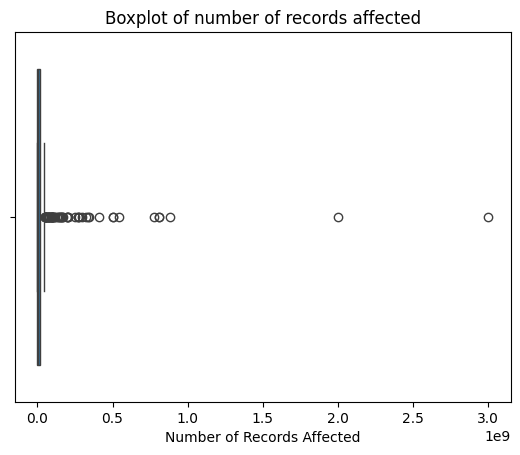

In [28]:
from matplotlib import pyplot as plt # https://pypi.org/project/matplotlib/ (https://matplotlib.org/stable/)
import seaborn as sns # https://pypi.org/project/seaborn/ (https://seaborn.pydata.org/tutorial.html)

print("\nPrinting the statistics of the \'Number of Records Affected\':")
print(clean_table["Number of Records Affected"].describe())

print("\nPrinting the boxplot of \'Number of Records Affected\':")
print(sns.boxplot(x=clean_table["Number of Records Affected"], showfliers = True))
plt.title("Boxplot of number of records affected")


Printing the entry of the Company with the largest 'Number of Records Affected':
    Company  Year  Number of Records Affected Organization Type  \
405   Yahoo  2013                3.000000e+09             [web]   

    Reasons for Breach                                  Reference Link(s)  
405           [hacked]  [[https://www.nytimes.com/2017/10/03/technolog...  

Printing the the boxplot of 'Number of Records Affected' without the outliers:


Text(0.5, 1.0, 'Boxplot of number of records affected (exempting outliers)')

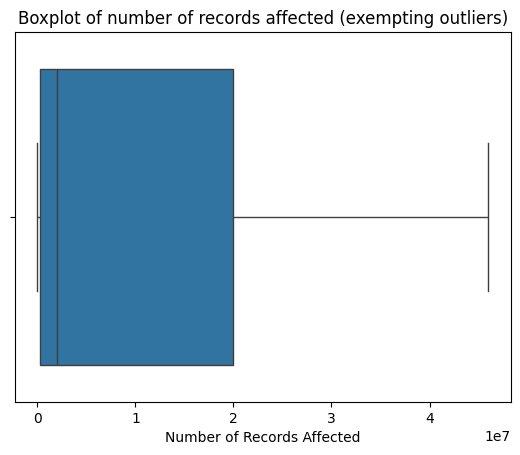

In [29]:
print("\nPrinting the entry of the Company with the largest \'Number of Records Affected\':")
print(clean_table.loc[clean_table["Number of Records Affected"] == clean_table["Number of Records Affected"].max()])

print("\nPrinting the the boxplot of \'Number of Records Affected\' without the outliers:")
sns.boxplot(x=clean_table["Number of Records Affected"], showfliers = False)
plt.title("Boxplot of number of records affected (exempting outliers)")


Printing a plot of the number of data breaches over time in years


Text(0.5, 1.0, 'Number of data breaches over time in years')

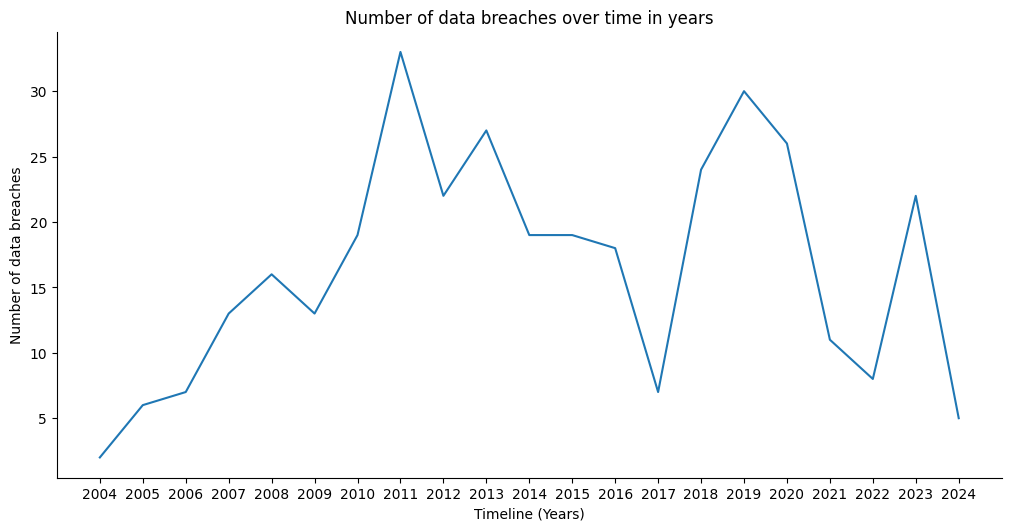

In [30]:
print("\nPrinting a plot of the number of data breaches over time in years")
sorted_by_year = clean_table.sort_values('Year', ascending=True)
counted = (sorted_by_year['Year'].value_counts()
            .reset_index(name='counts')
            .rename({'index': 'Year'}, axis=1)
            .sort_values('Year', ascending=True))
x_axis = counted['Year']
y_axis = counted['counts']
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
sns.despine(fig=fig, ax=ax)
plt.plot(x_axis, y_axis, label="")
plt.xlabel("Timeline (Years)")
plt.ylabel("Number of data breaches")
plt.title("Number of data breaches over time in years")

At the beginning of the analysis section, the numerical statistics of "Number of Records Affected" are outputted into the terminal through the describe() method. From this, we can see that the minimum values are within 3 standard deviations from the mean, so there are no outliers on the lower bounds. This cannot be said on the other end, as the maximun value is outside the range of 3 standard deviations from the mean. This means there is at least one outlier on the higher bounds. This can be displayed through a boxplot using the boxplot() method under the *seaborn* library. The boxplot show the data is extremely skewed towards the right, as the boxplot lies on the left side of the graph with many outliers towards the right. One outlier seems to be extremely high, so we use the loc() and max() methods to find the data entry with the highest "Number of Records Affected. The outputted entry is Yahoo, who got hacked in 2013 and leaked 3,000,000,000 records. A boxplot is outputted next, showing the same data without all the outliers for easier digestion. After, the graph shown displays the number of data breaches that occur over a timeline measured in years. This is achieved by first sorting the clean_table based on the year of occurrance. The value_counts() method is then used to tally up the number of breaches that occur within the same year, outputted using the plot() method. From this graph, we can see the years 2011 and 2019 have experienced spikes in data breaches. There are many factors that can contribute to this fact. Recently, there has been an increase in data breaches after an initial decrease in the past two years. With this in mind, we may experience another peak in data breaches in the near future similar to 2011 and 2019.